<a href="https://colab.research.google.com/github/syenirasheila/Detection-of-Rice-Leaf-Disease-in-Indonesia-InceptionV3/blob/main/Final_Detection_Rice_Leaf_Disease_Indonesia_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PENGUMPULAN DATA

In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [ ]:
#koneksi google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE = (299, 299) # resolution
directory = "/content/drive/MyDrive/Machine Learning 117/Penyakit_Daun_Padi_Indonesia"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 240 files belonging to 3 classes.
Using 192 files for training.
Found 240 files belonging to 3 classes.
Using 48 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['blas', 'hawar_daun', 'tungro']

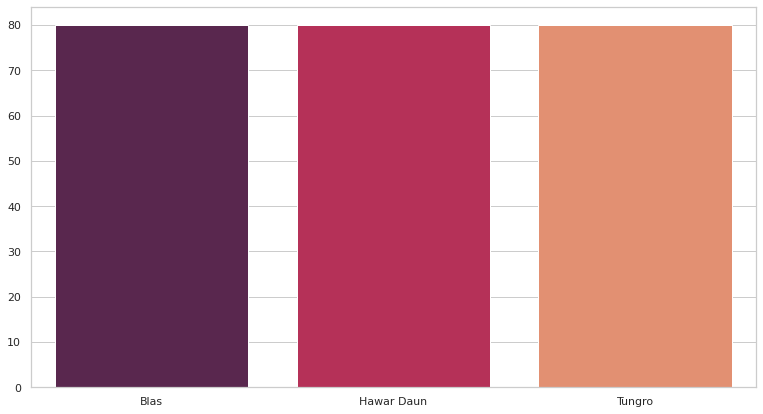

In [ ]:
#eksplorasi dataset
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Blas", "Hawar Daun", "Tungro"], y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 0.75
Weight for class 1: 0.75
Weight for class 2: 0.75


# PRE-PROCESSING

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])


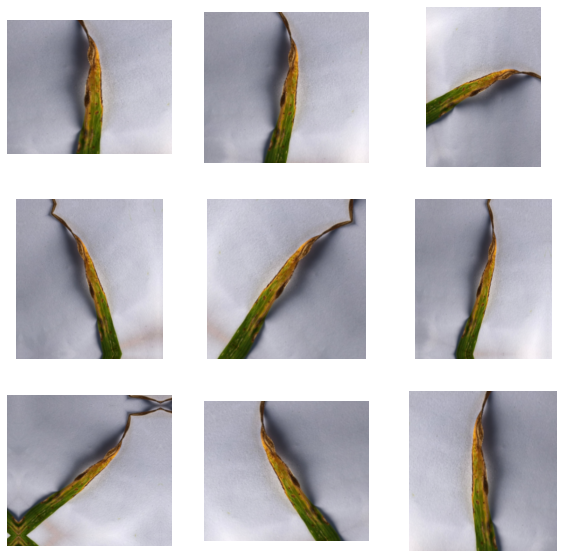

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

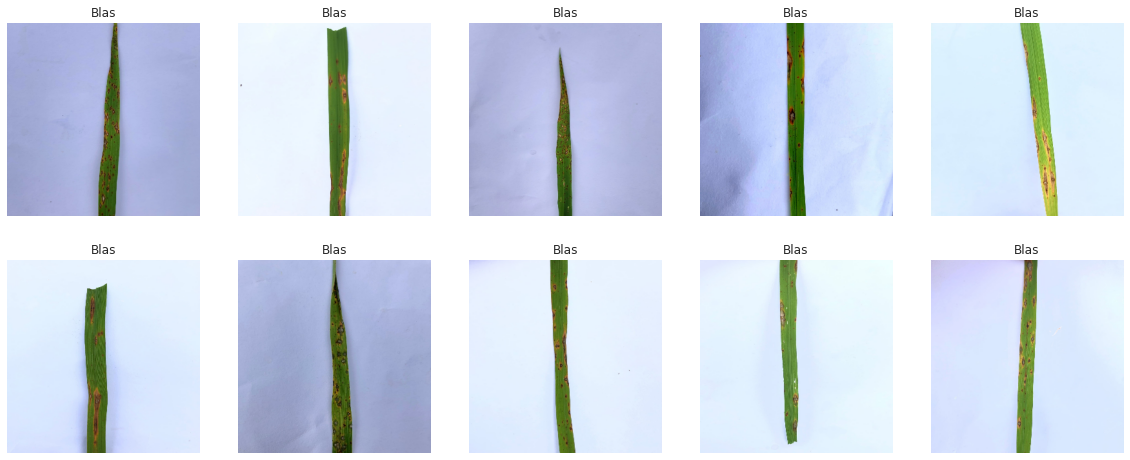

In [ ]:
plt.figure(figsize=(20,8))
Blas = []
Hawar_Daun = []
Tungro = []
for images , labels in train_dataset.take(1):
    for i in range(100):
        if  class_names[labels[i]] == "blas":
            Blas.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "hawar_daun":
            Hawar_Daun.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "tungro":
            Tungro.append(images[i].numpy().astype("uint8"))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Blas[i])
    plt.axis("off")
    plt.title("Blas")

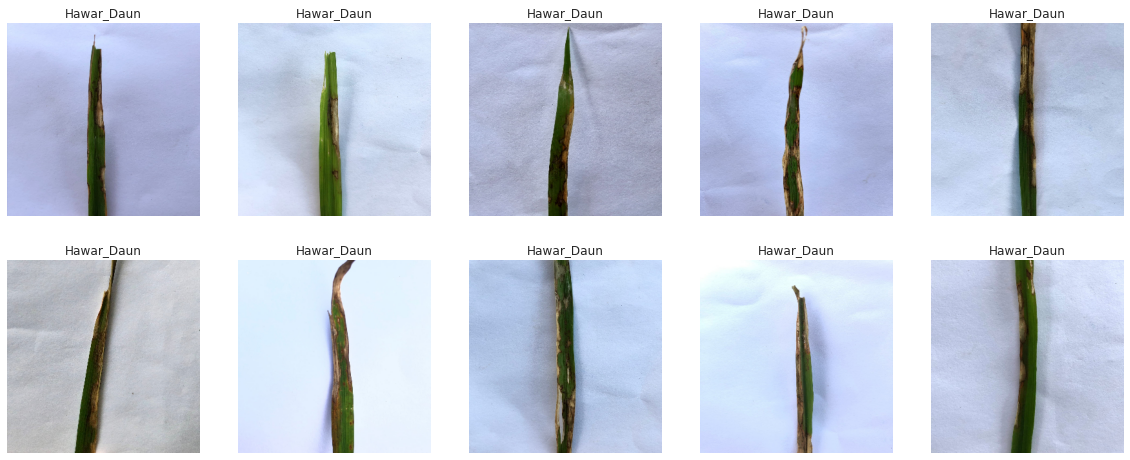

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Hawar_Daun[i])
    plt.axis("off")
    plt.title("Hawar_Daun")

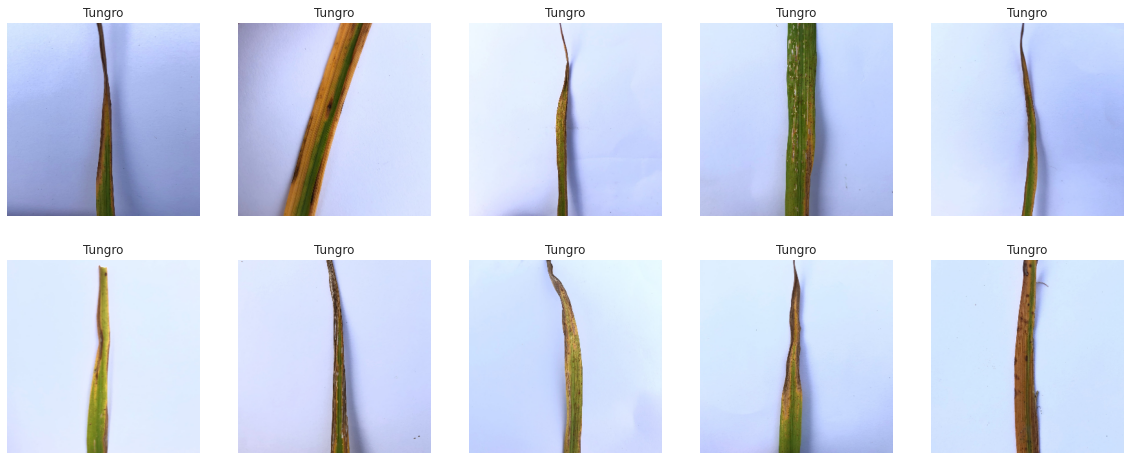

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Tungro[i])
    plt.axis("off")
    plt.title("Tungro")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# METODE KLASIFIKASI CNN


In [ ]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

In [ ]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_281
mixed10


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 8, 8, 2048)


In [ ]:
def model_penyakit_daun_padi( image_shape=IMG_SIZE):
    '''tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
Model_Penyakit_Daun_Padi = model_penyakit_daun_padi(IMG_SIZE)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

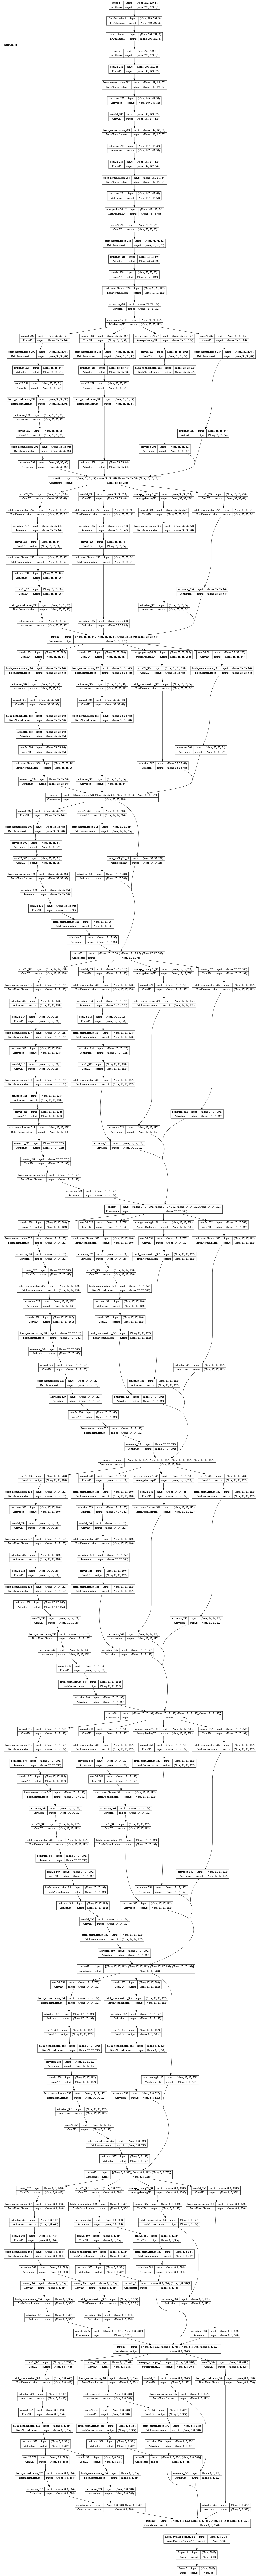

In [ ]:
import tensorflow as tf
model_viz = tf.keras.utils.plot_model(Model_Penyakit_Daun_Padi,
                          to_file='xception.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
base_learning_rate = 0.001
Model_Penyakit_Daun_Padi.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
history = Model_Penyakit_Daun_Padi.fit(train_dataset , verbose=2 , epochs=10,
                               validation_data=validation_dataset , use_multiprocessing= True)

Epoch 1/10
2/2 - 84s - loss: 1.6958 - accuracy: 0.3125 - val_loss: 3.7001 - val_accuracy: 0.3750 - 84s/epoch - 42s/step
Epoch 2/10
2/2 - 66s - loss: 3.2910 - accuracy: 0.3906 - val_loss: 3.1775 - val_accuracy: 0.3958 - 66s/epoch - 33s/step
Epoch 3/10
2/2 - 75s - loss: 2.9650 - accuracy: 0.3177 - val_loss: 0.9240 - val_accuracy: 0.5417 - 75s/epoch - 37s/step
Epoch 4/10
2/2 - 72s - loss: 0.6603 - accuracy: 0.7188 - val_loss: 0.5438 - val_accuracy: 0.7917 - 72s/epoch - 36s/step
Epoch 5/10
2/2 - 73s - loss: 0.2861 - accuracy: 0.9062 - val_loss: 0.4306 - val_accuracy: 0.8750 - 73s/epoch - 36s/step
Epoch 6/10
2/2 - 65s - loss: 0.2166 - accuracy: 0.9479 - val_loss: 0.3439 - val_accuracy: 0.8958 - 65s/epoch - 32s/step
Epoch 7/10
2/2 - 72s - loss: 0.1755 - accuracy: 0.9479 - val_loss: 0.3587 - val_accuracy: 0.8958 - 72s/epoch - 36s/step
Epoch 8/10
2/2 - 72s - loss: 0.1355 - accuracy: 0.9635 - val_loss: 0.3259 - val_accuracy: 0.9167 - 72s/epoch - 36s/step
Epoch 9/10
2/2 - 73s - loss: 0.1021 - ac

In [ ]:
#melihat nilai acc dan loss
Model_Penyakit_Daun_Padi.evaluate(validation_dataset , verbose = 1)

1/1 [==============================] - 13s 13s/step - loss: 0.3076 - accuracy: 0.9375


[0.3075501024723053, 0.9375]

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Model_Penyakit_Daun_Padi(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)


# EVALUASI MODEL

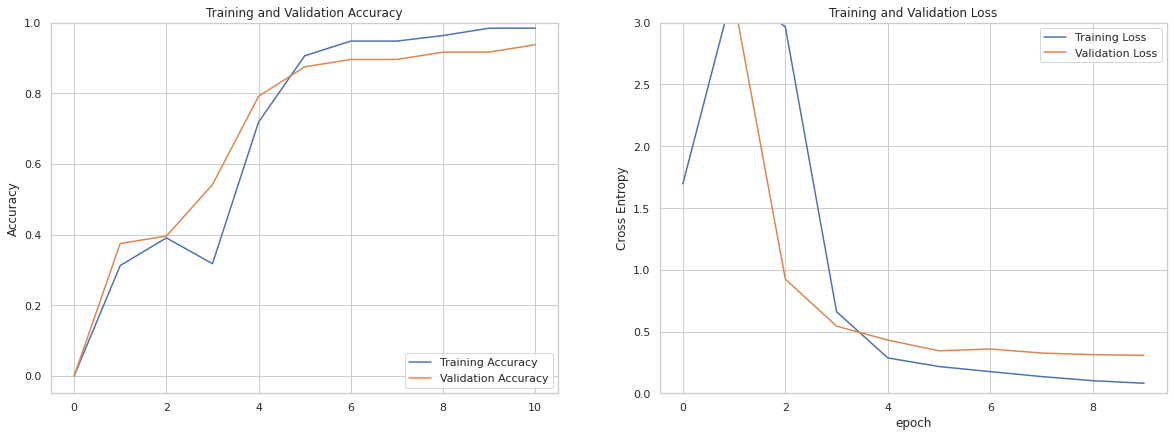

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#plot MSE
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#plot MAE
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()